# Notebook for carrying out clustering of agegroups

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib widget

# Load style
plt.style.use('PlotStyle.mplstyle')
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

from datetime import datetime
from tqdm import tqdm

import os

# Load functions
import sys
sys.path.append("../../ExcessMortality")
import ExcessMortalityFunctions as emf
import AdditionalFunctions as ps


saveFigures = True
saveFigures = False
print('saveFigures is set to: '+str(saveFigures))
print('Done loading packages')

saveFigures is set to: False
Done loading packages


In [2]:
# Set paths
pathData = '../Data/'
pathResults = '../Data/AnalysisResults'
pathFigs = '../Figures/'

In [3]:
# Flags and analysis parameters used in main analysis, set here to load correct results
numYears = 12 # Number of years on both sides of date to use for baseline calculations 
numYearsTot = (numYears*2) # The "name" of the baseline (i.e. +/- 5 years is a 10-year baseline, +/- 12 is a 24 year baseline)
thresholdExcess = 3 # Threshold (in terms of Z-scores) for identifying a day as having increased excess

# Additional parameters used
thresholdLower = 2 # Lower threshold used for determining the start and end of periods (in terms of Z-scores)
# maxDaysBelowThreshold = 4 # Number of days below thresholdLower before a period of excess is "stopped"
# minimumLengthOfEpidemic = 4 # Minimal number of days above thresholdExcess which is counted as a period of excess 
maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
minimumLengthOfEpidemic = 0 # Minimal number of days above thresholdExcess which is counted as a period of excess 
excessCountThreshold = 50 # Only save mortality crises with more than this number of excess deaths


# numYears = 6 # Number of years on both sides of date to use for baseline calculations 
# numYears = 9 # Number of years on both sides of date to use for baseline calculations 
# maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
# excessCountThreshold = 20 # Only save mortality crises with more than this number of excess deaths

# Determine filename to use for final results
# finalResultsFilename = 'AllCrises'+f'_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename = 'AllCrises'+f'_NonSmoothed_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename

'AllCrises_NonSmoothed_Years12_Threshold3_LowerThreshold2_MaxDaysBelow7_minLength0_minCount50'

In [4]:
# Define the agegroups analyzed
ageGroupsAll = [
    ['Total'],
    ['Stillborn','0'],
    ['1-4','5-9', '10-14'],
    ['15-19', '20-24', '25-29', '30-34', '35-39'],
    ['40-44', '45-49', '50-54', '55-59'],
    ['60-64', '65-69', '70-74', '75-79', '80+']
]

# And the names used for directories and filenames
ageGroupNamesAll = [
    'Total',
    'Infants_stillborn',
    '1-14',
    '15-39',
    '40-59',
    '60+'
]
ageGroups = ageGroupsAll[1:]
ageGroupNames = ageGroupNamesAll[1:]

# Load table with all crises

In [5]:
dfCrises = pd.read_csv(pathData + finalResultsFilename + '.csv')

dfCrises['Start'] = pd.to_datetime(dfCrises['Start'])
dfCrises['End'] = pd.to_datetime(dfCrises['End'])
# dfCrises['DayWithMostBurials'] = pd.to_datetime(dfCrises['DayWithMostBurials'])
dfCrises['DayWithMostDeaths'] = pd.to_datetime(dfCrises['DayWithMostDeaths'])

dfCrises = dfCrises.sort_values(by='Excess',ascending=False).reset_index(drop=True)


# Prepare data to use for clustering

In [6]:
# Use the columns with excess burials in each agegroup (and make sure to not use "Total" as well)
curCols = ageGroupNames
colsToUse = ['Exc_'+x for x in curCols]


In [7]:
# Get part of dataframe with age-specific excess
curdf = dfCrises[colsToUse].copy()

# Set negative values to 0
curdf[curdf < 0] = 0

# Calculate how big a proportion of all mortality is due to the given age group
fracdf = curdf.apply(lambda x: x/curdf.sum(axis=1)) 

# Get as array
curData = fracdf.to_numpy()

# # Make a shorter version for tests with clustering
# curDataShort = curData[:100,:]
# # curDataShort = curData[:50,:]
# curDataShort.shape

In [8]:

# Add the numbers in fracdf to the main dataframe, so they are also saved later
newCols = ['FracAll_'+x for x in curCols]
dfToAppend = fracdf.rename(columns=dict(zip(fracdf.columns,newCols)))

# Append the fraction
dfCrises = dfCrises.join(dfToAppend)

# Save the sum of excess to main dataframe
dfCrises['AgeSplitSumExc'] = curdf.sum(axis=1)

In [9]:
# dfCrises

# Clustering

### Start by checking the aic and bic of different numbers of clusters

In [10]:
curData.shape

(418, 5)

In [11]:
# from sklearn import mixture

# dataToUse = curData[:150]
# dataToUse = curData[:100]
# dataToUse = curData[:200]
# # dataToUse = curData[:250]
# # dataToUse = curData

# fig,(ax,ax2) = plt.subplots(2,1)
# # for numClusters in tqdm(range(2,2)):
# for numClusters in tqdm(range(2,12)):
    
#     # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
#     clf = mixture.GaussianMixture(n_components=numClusters, n_init = 150,covariance_type="tied")
#     clf.fit(dataToUse)

#     ax.plot(numClusters,clf.aic(dataToUse),'s')
#     ax2.plot(numClusters,clf.bic(dataToUse),'s')

In [12]:
from sklearn import mixture

dataToUse = curData[:150]
dataToUse = curData[:100]
dataToUse = curData[:200]
# dataToUse = curData[:250]
# dataToUse = curData

clusterRange = np.arange(3,11)
dataRange = np.arange(50,len(curData),50)


# fig,(ax,ax2) = plt.subplots(2,1)
fig,ax2 = plt.subplots(figsize=(12,6))


for numData in tqdm(dataRange):
    curBics = []
    
    dataToUse = curData[:numData]

    # for numClusters in tqdm(clusterRange):
    for numClusters in clusterRange:

        
        # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
        clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,covariance_type="tied")
        clf.fit(dataToUse)

        curBics.append(clf.bic(dataToUse))

    ax2.plot(clusterRange,curBics / -np.min(curBics),'.-',label=numData)
        # ax2.plot(numClusters,clf.bic(dataToUse),'s')

ax2.legend(title= 'Crises used in fitting')
ax2.set_ylabel('BIC relative to minimum BIC')
ax2.set_xlabel('Number of clusters')
ax2.set_ylim([-1,-0.97])
    
if saveFigures:
    fig.savefig(pathFigs+'Supplementary_BIC')

In [13]:
from sklearn import mixture

dataToUse = curData[:150]
dataToUse = curData[:100]
dataToUse = curData[:200]
# dataToUse = curData[:250]
# dataToUse = curData

clusterRange = np.arange(3,11)
dataRange = np.arange(50,len(curData),50)


# fig,(ax,ax2) = plt.subplots(2,1)
# fig,ax2 = plt.subplots(figsize=(12,6))


for numData in tqdm(dataRange):
    curBics = []
    
    dataToUse = curData[:numData]

    # for numClusters in tqdm(clusterRange):
    for numClusters in clusterRange:

        
        # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
        clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,covariance_type="tied")
        clf.fit(dataToUse)

        curBics.append(clf.bic(dataToUse))

    fig,ax2 = plt.subplots()
    # ax2.plot(clusterRange,curBics / -np.min(curBics),'.-',label=numData)
    ax2.plot(clusterRange,curBics,'.-',label=numData)
        # ax2.plot(numClusters,clf.bic(dataToUse),'s')

    ax2.legend(title= 'Crises used in fitting')
    ax2.set_ylabel('BIC relative to minimum BIC')
    ax2.set_xlabel('Number of clusters')
    # ax2.set_ylim([-1,-0.97])
    
# if saveFigures:
#     fig.savefig(pathFigs+'Supplementary_BIC')

In [14]:
# plt.close('all')

In [15]:







# dataToUse = curData[:100]
dataToUse = curData[:150]








In [166]:
# Fit Gaussian Mixture Model 
from sklearn import mixture

# Define model
numClusters = 6
# numClusters = 7
# numClusters = 8
# numClusters = 10
gmm = mixture.GaussianMixture(n_components=numClusters, random_state = 1,n_init=100, init_params='kmeans', covariance_type="tied")

# Fit to data
# gmm.fit(curData)
gmm.fit(dataToUse)
# Get prediction labels
gmmLabels = gmm.predict(curData)

# Also calculate probabilities of belonging to other clusters
allProbas = gmm.predict_proba(curData)

In [167]:
# Name clusters letters instead of numbers
dfMeans = pd.DataFrame(gmm.means_)

# # # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# # curSortIndex = dfMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# # New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
# curSortIndex = dfMeans.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index

# dfMeans = dfMeans.loc[curSortIndex]
# # dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)

# New ordering, December 2023
orderVal = dfMeans.loc[:,0] + dfMeans.loc[:,1] * 0.5 - dfMeans.loc[:,4]
newSortIndex = np.argsort(orderVal)[::-1]
dfMeans = dfMeans.loc[newSortIndex]
# dfMeans = dfMeans.loc[newSortIndex].reset_index(drop=True)



# Name according to current order
curClusters = np.arange(numClusters)
clusterNameDictTable = dict(zip(dfMeans.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict = dict(zip(curClusters,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

clusterNumDict = dict(zip(dfMeans.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [168]:
# clusterNumDict

# clusterNameDict = dict(zip(curClusters,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...
# clusterNameDict


In [169]:

# dfMeans = pd.DataFrame(gmm.means_)

# orderVal = dfMeans.loc[:,0] + dfMeans.loc[:,1] * 0.5 - dfMeans.loc[:,4]
# newSortIndex = np.argsort(orderVal)[::-1]
# dfMeans = dfMeans.loc[newSortIndex]
# dfMeans

# curClusters = np.arange(numClusters)
# clusterNameDict = dict(zip(dfMeans.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

# clusterNumDict = dict(zip(dfMeans.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
# clusterNameDict

In [170]:
clusterNameDict
clusterNumDict

{2: 0, 0: 1, 1: 2, 4: 3, 5: 4, 3: 5}

In [171]:

# orderVal = dfMeans.loc[:,0] + dfMeans.loc[:,1] * 0.5 - dfMeans.loc[:,4]
# orderVal

# dfCrises.loc[gmmLabels == 3]

In [172]:
# gmmLabelsLetter = [clusterNameDict[x] for x in gmmLabels]
gmmLabelsLetter = [clusterNameDictTable[x] for x in gmmLabels]


In [232]:
# Save results to main dataframe
dfCrisesLabel = dfCrises.copy()
# dfCrisesLabel.loc[:len(curData)-1,'Cluster'] = gmmLabels
dfCrisesLabel.loc[:len(curData)-1,'Cluster'] = gmmLabelsLetter

# for k in range(numClusters):
for k in clusterNameDict.keys():
    # dfCrisesLabel[f'Cluster{k}_Prob'] = allProbas[:,k].round(4)
    curLetter = clusterNameDict[k]
    dfCrisesLabel[f'Cluster{curLetter}_Prob'] = allProbas[:,k].round(4)

In [235]:
# dfCrisesLabel.head(20)

# Save clustering results to file

In [236]:
import pickle 

# save
with open(f'GMM_model_Results.pkl','wb') as f:
    pickle.dump(gmm,f)
    
# # load
# with open('GMM_model_Results.pkl', 'rb') as f:
#     clf2 = pickle.load(f)
# # np.all(allProbas == clf2.predict_proba(pcaDataFull))

In [237]:

dfCrisesLabelToSave = dfCrisesLabel.copy()

curFileName = finalResultsFilename + '_Clustered'
dfCrisesLabelToSave.to_csv(pathData + '/' + curFileName + '.csv',index=False)

dfCrisesLabelExcel = dfCrisesLabelToSave.copy()
dfCrisesLabelExcel['Start'] = dfCrisesLabelExcel['Start'].astype(str)
dfCrisesLabelExcel['End'] = dfCrisesLabelExcel['End'].astype(str)
# dfCrisesLabelExcel['DayWithMostBurials'] = dfCrisesLabelExcel['DayWithMostBurials'].astype(str)
dfCrisesLabelExcel['DayWithMostDeaths'] = dfCrisesLabelExcel['DayWithMostDeaths'].astype(str)


dfCrisesLabelExcel.to_excel(pathData + '/' + curFileName + '.xlsx',index=False)


# Make clustering figures

In [177]:
import matplotlib.cm as cm
# Sort clusters (and name)
cmap = cm.get_cmap('jet',numClusters)
cmapBar = cm.get_cmap('rainbow')



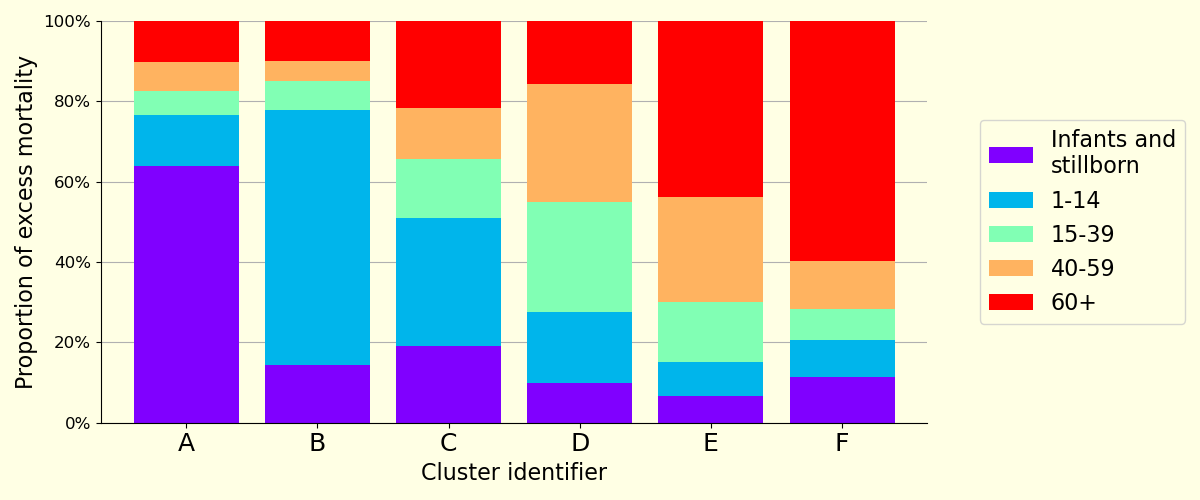

In [178]:

# dfMeans.columns = ageGroupNames[1:]

dfMeans.columns = ageGroupNames

# dfMeans = dfMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

fig,ax = plt.subplots(figsize=(12,5))
(dfMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax.set_xlabel('Cluster identifier',fontsize=16)
ax.set_ylabel('Proportion of excess mortality',fontsize=16)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)

# ax.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])
ax.set_xticklabels([clusterNameDict[x] for x in curClusters])

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_ClustersIllustration')

In [179]:

# dfMeans = pd.DataFrame(gmm.means_)
# dfMeans.cumsum(axis=1).round(1)

dfMeans 

,Infants and\nstillborn,1-14,15-39,40-59,60+
2,0.639851,0.125189,0.061482,0.072080,0.101398
0,0.142984,0.634571,0.073362,0.050477,0.098606
1,0.191146,0.318939,0.146893,0.126373,0.216648
4,0.098306,0.177165,0.274207,0.292313,0.158010
5,0.065684,0.085835,0.147875,0.263352,0.437254
3,0.113033,0.092082,0.077851,0.120311,0.596722


In [180]:
# clusterNameDict
# clusterNumDict

In [181]:

# dfMeans = pd.DataFrame(gmm.means_)

# dfMeans.columns = ageGroupNames

# # dfMeans = dfMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
# dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})


# fig,ax = plt.subplots(figsize=(12,5))
# (dfMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
# ax.set_axisbelow(True)
# ax.set_ylim([0,100])
# ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
# ax.set_xlabel('Cluster identifier')
# ax.set_ylabel('Proportion of excess mortality')
# from matplotlib.ticker import FormatStrFormatter
# ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))


# plt.xticks(rotation=0)

# ax.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])

# fig.tight_layout()

# if saveFigures:
#     fig.savefig(pathFigs+'Supplementary_ClustersIllustration_InOrder')

In [182]:
clusterNumDict
clusterNameDict
invMap = {v: k for k, v in clusterNameDict.items()}
invMap

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [183]:
clusterNameDict

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [184]:
# # fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))
# fig,allAxes = plt.subplots(4,4,figsize=(15,15))
# # fig,allAxes = plt.subplots(5,5)

# showLabels = True
# showLabels = False

# for ax in allAxes.flatten():
    
#     ax.axis('equal')
    
# # for i,r in dfCrises.iloc[:40].iterrows():
# # for i,r in dfCrisesLabel.iloc[:len(curDataShort)].iterrows():
# for i,r in dfCrisesLabel.iterrows():
# # for i,r in dfCrisesLabel.iloc[:30].iterrows():

#     # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
#     (cur1,cur2,cur3,cur4,cur5) = curData[i]

#     curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
#     # curColor = cmap(r.Cluster/numClusters)
#     # curColor = cmap(curSortIndex[r.Cluster]/numClusters)
#     # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
#     curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    
#     # curSortIndex
#     # curColor = r.Disease
#     # curLabel = r.Disease

#     allAxes[0,0].plot(cur5,cur4,'.',color=curColor)

#     allAxes[1,0].plot(cur5,cur3,'.',color=curColor)
#     allAxes[1,1].plot(cur4,cur3,'.',color=curColor)
    
#     allAxes[2,0].plot(cur5,cur2,'.',color=curColor)
#     allAxes[2,1].plot(cur4,cur2,'.',color=curColor)
#     allAxes[2,2].plot(cur3,cur2,'.',color=curColor)
    
#     allAxes[3,0].plot(cur5,cur1,'.',color=curColor)
#     allAxes[3,1].plot(cur4,cur1,'.',color=curColor)
#     allAxes[3,2].plot(cur3,cur1,'.',color=curColor)
#     allAxes[3,3].plot(cur2,cur1,'.',color=curColor)

#     if showLabels:
#         allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
# labelFontSize = 14
# # allAxes[3,4].set_xlabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
# allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
# allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
# allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
# allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
# allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
# allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
# allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
# allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
# allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

# # allAxes[3,0].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# # allAxes[3,1].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# # allAxes[3,2].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# # allAxes[3,3].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
# allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
# allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
# allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
# allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
# allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
# allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
# allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
# allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
# allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)
# # allAxes[3,0].set_ylabel('60+',fontsize=labelFontSize)


# allAxes[0,1].axis(False)
# allAxes[0,2].axis(False)
# allAxes[0,3].axis(False)
# allAxes[1,2].axis(False)
# allAxes[1,3].axis(False)
# allAxes[2,3].axis(False)


In [185]:
# # dfCrisesLabel
# # clusterNumDict
# invMap

# dfCrisesLabel.head(20)


In [186]:
dfMeans.loc[5,:]


invMap['D']

3

In [187]:
# dfMeans.loc[4,:]
# invMap[r.Cluster]

# newSortIndex[invMap[r.Cluster]]
# clusterNumDict[2]

In [188]:

# fig,ax = plt.subplots()

# curdfCri = dfCrisesLabel[dfCrisesLabel.Cluster == 'F']
# for i,r in curdfCri.iterrows():
# # for i,r in dfCrisesLabel.iloc[:20].iterrows():

#     # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
#     (cur1,cur2,cur3,cur4,cur5) = curData[i]
#     curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)

#     ax.plot(cur4,cur5,'.',color=curColor)



In [189]:
# # invMap['A']

# fig,ax = plt.subplots()
# # for i,r in dfCrisesLabel.iterrows():
# for i,r in dfCrisesLabel.iloc[:20].iterrows():

#     # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
#     (cur1,cur2,cur3,cur4,cur5) = curData[i]
#     curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)

#     ax.plot(cur4,cur5,'.',color=curColor)


# clusterNum = 0
# # for clusterNum in range(numClusters):
# # for i,clusterNum in enumerate(curSortIndex):
# for i,clusterNum in enumerate(range(numClusters)):
#     # curMean = gmm.means_[clusterNum,:]
#     # curMean = gmm.means_[curSortIndex[clusterNum],:]
#     curMean = dfMeans.iloc[clusterNum,:]
#     # curMean = dfMeans.iloc[clusterNumDict[newSortIndex[clusterNum]],:]
    
    
#     mea1,mea2,mea3,mea4,mea5 = curMean  

#     curColor = cmap(i/numClusters)

    
#     ax.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14)
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

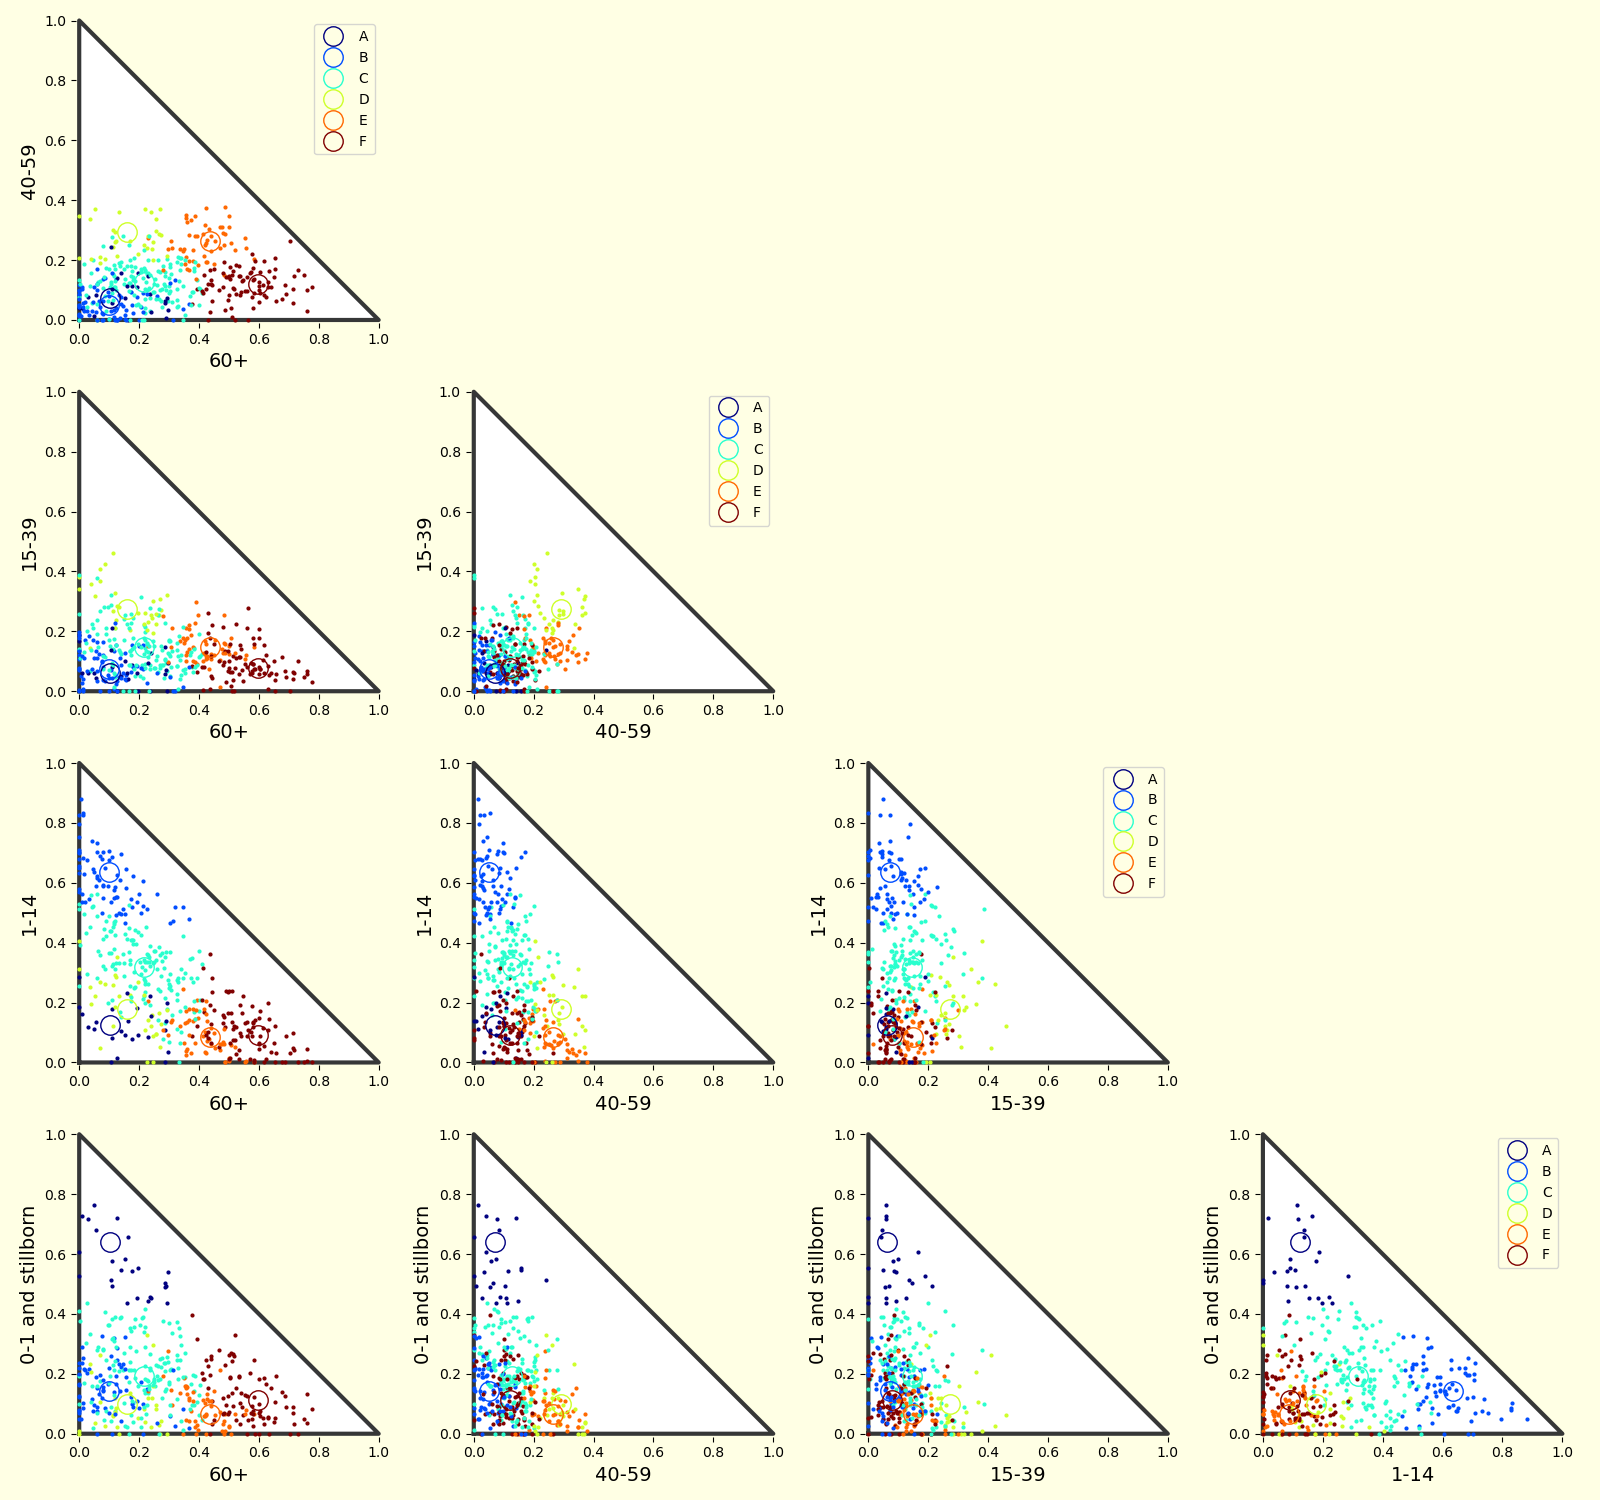

In [210]:
fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(16,15))
# fig,allAxes = plt.subplots(5,5)

showLabels = True
showLabels = False

for ax in allAxes.flatten():
    ax.set_aspect('equal', adjustable='box')


# for i,r in dfCrises.iloc[:40].iterrows():
# for i,r in dfCrisesLabel.iloc[:len(curDataShort)].iterrows():
for i,r in dfCrisesLabel.iterrows():
# for i,r in dfCrisesLabel.iloc[:30].iterrows():

    # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
    (cur1,cur2,cur3,cur4,cur5) = curData[i]

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    # curColor = cmap(r.Cluster/numClusters)
    # curColor = cmap(curSortIndex[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    # curColor = cmap(invMap[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)

    
    # curSortIndex
    # curColor = r.Disease
    # curLabel = r.Disease

    allAxes[0,0].plot(cur5,cur4,'.',ms=4,color=curColor)

    allAxes[1,0].plot(cur5,cur3,'.',ms=4,color=curColor)
    allAxes[1,1].plot(cur4,cur3,'.',ms=4,color=curColor)
    
    allAxes[2,0].plot(cur5,cur2,'.',ms=4,color=curColor)
    allAxes[2,1].plot(cur4,cur2,'.',ms=4,color=curColor)
    allAxes[2,2].plot(cur3,cur2,'.',ms=4,color=curColor)
    
    allAxes[3,0].plot(cur5,cur1,'.',ms=4,color=curColor)
    allAxes[3,1].plot(cur4,cur1,'.',ms=4,color=curColor)
    allAxes[3,2].plot(cur3,cur1,'.',ms=4,color=curColor)
    allAxes[3,3].plot(cur2,cur1,'.',ms=4,color=curColor)

    
    if showLabels:
        allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
labelFontSize = 14
# allAxes[3,4].set_xlabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

# allAxes[3,0].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,1].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,2].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,3].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)
# allAxes[3,0].set_ylabel('60+',fontsize=labelFontSize)

allAxes[0,1].axis(False)
allAxes[0,2].axis(False)
allAxes[0,3].axis(False)
allAxes[1,2].axis(False)
allAxes[1,3].axis(False)
allAxes[2,3].axis(False)



clusterNum = 0
# for clusterNum in range(numClusters):
# for i,clusterNum in enumerate(curSortIndex):
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = curMean  

    curColor = cmap(i/numClusters)
    curLabel = clusterNameDict[clusterNum]

    # import matplotlib as mpl
    # covar = gmm.covariances_[:2,:2]
    # v, w = np.linalg.eigh(covar)
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    # u = w[0] / np.linalg.norm(w[0])
    # # Plot an ellipse to show the Gaussian component
    # angle = np.arctan(u[1] / u[0])
    # angle = 180.0 * angle / np.pi  # convert to degrees
    # # ell = mpl.patches.Ellipse((curMeans[0],curMeans[1]), v[0], v[1], angle=180.0 + angle, color='k')
    # # ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], angle=180.0 + angle, color='k')
    # # ell = mpl.patches.Ellipse(gmm.means_[clusterNum,:2], v[0], v[1], angle=180.0 + angle, color='k')
    # ell = mpl.patches.Ellipse((mea2,mea1), v[0], v[1], angle=180.0 + angle, color=curColor,linewidth=0)
    # ell.set_alpha(0.25)
    # allAxes[3,3].add_patch(ell)
    
    # ell = mpl.patches.Ellipse((mea5,mea4), v[0], v[1], angle=180.0 + angle, color=curColor,linewidth=0)
    # ell.set_alpha(0.5)
    # allAxes[0,0].add_patch(ell)

    
    allAxes[0,0].plot(mea5,mea4,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

    allAxes[1,0].plot(mea5,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[2,0].plot(mea5,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[3,0].plot(mea5,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

# allAxes[0,0].legend(loc='center left',bbox_to_anchor = (1.05,0.5))
allAxes[0,0].legend()
allAxes[1,1].legend()
allAxes[2,2].legend()
allAxes[3,3].legend()

for ax in allAxes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

    ax.set_xlim([-0.01,1.01])
    ax.set_ylim([-0.01,1.01])

    ax.grid(False)
        
    coords = [[0,0],[1,0],[0,1],[0,0]]
    xs,ys = zip(*coords)
    ax.fill(xs,ys,color='w',zorder=-2)
        
allAxes[0,1].remove()
allAxes[0,2].remove()
allAxes[0,3].remove()
allAxes[1,2].remove()
allAxes[1,3].remove()
allAxes[2,3].remove()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_Pointcloud')

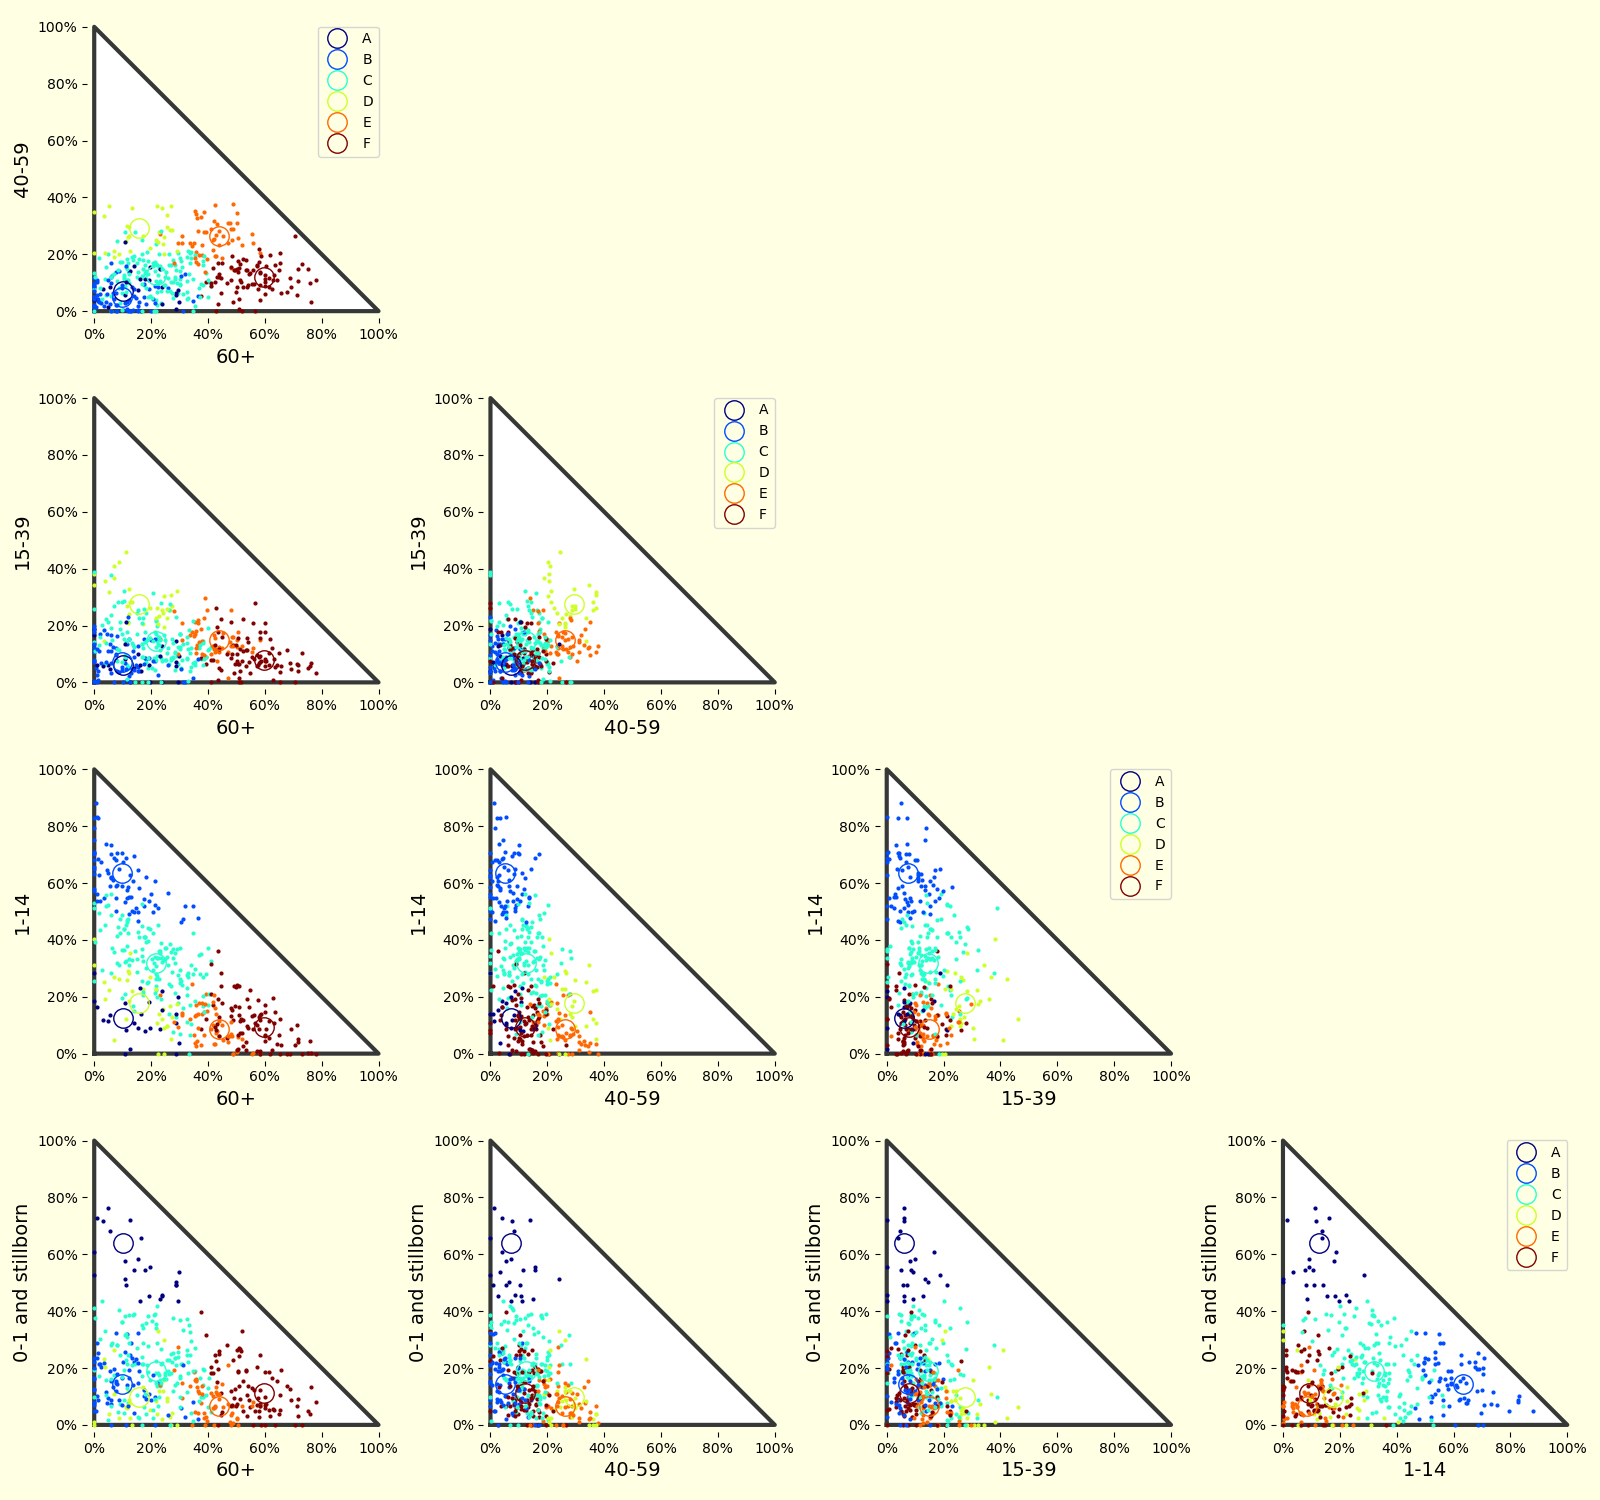

In [211]:
fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(16,15))
# fig,allAxes = plt.subplots(5,5)

showLabels = True
showLabels = False

for ax in allAxes.flatten():
    ax.set_aspect('equal', adjustable='box')

# for i,r in dfCrises.iloc[:40].iterrows():
# for i,r in dfCrisesLabel.iloc[:len(curDataShort)].iterrows():
for i,r in dfCrisesLabel.iterrows():
# for i,r in dfCrisesLabel.iloc[:30].iterrows():

    # (cur1,cur2,cur3,cur4,cur5) = curDataShort[i]
    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    # curColor = cmap(r.Cluster/numClusters)
    # curColor = cmap(curSortIndex[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    # curSortIndex
    # curColor = r.Disease
    # curLabel = r.Disease

    allAxes[0,0].plot(cur5,cur4,'.',ms=4,color=curColor)

    allAxes[1,0].plot(cur5,cur3,'.',ms=4,color=curColor)
    allAxes[1,1].plot(cur4,cur3,'.',ms=4,color=curColor)
    
    allAxes[2,0].plot(cur5,cur2,'.',ms=4,color=curColor)
    allAxes[2,1].plot(cur4,cur2,'.',ms=4,color=curColor)
    allAxes[2,2].plot(cur3,cur2,'.',ms=4,color=curColor)
    
    allAxes[3,0].plot(cur5,cur1,'.',ms=4,color=curColor)
    allAxes[3,1].plot(cur4,cur1,'.',ms=4,color=curColor)
    allAxes[3,2].plot(cur3,cur1,'.',ms=4,color=curColor)
    allAxes[3,3].plot(cur2,cur1,'.',ms=4,color=curColor)

    
    if showLabels:
        allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
labelFontSize = 14
# allAxes[3,4].set_xlabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

# allAxes[3,0].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,1].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,2].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
# allAxes[3,3].set_ylabel('Infants and stillborn',fontsize=labelFontSize)
allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)
# allAxes[3,0].set_ylabel('60+',fontsize=labelFontSize)

allAxes[0,1].axis(False)
allAxes[0,2].axis(False)
allAxes[0,3].axis(False)
allAxes[1,2].axis(False)
allAxes[1,3].axis(False)
allAxes[2,3].axis(False)



clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
# # for clusterNum in range(numClusters):
# for i,clusterNum in enumerate(curSortIndex):
#     curMean = gmm.means_[clusterNum,:]
#     # curMean = gmm.means_[curSortIndex[clusterNum],:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = clusterNameDict[clusterNum]

    # import matplotlib as mpl
    # covar = gmm.covariances_[:2,:2]
    # v, w = np.linalg.eigh(covar)
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    # u = w[0] / np.linalg.norm(w[0])
    # # Plot an ellipse to show the Gaussian component
    # angle = np.arctan(u[1] / u[0])
    # angle = 180.0 * angle / np.pi  # convert to degrees
    # # ell = mpl.patches.Ellipse((curMeans[0],curMeans[1]), v[0], v[1], angle=180.0 + angle, color='k')
    # # ell = mpl.patches.Ellipse(gmm.means_[n,:2], v[0], v[1], angle=180.0 + angle, color='k')
    # # ell = mpl.patches.Ellipse(gmm.means_[clusterNum,:2], v[0], v[1], angle=180.0 + angle, color='k')
    # ell = mpl.patches.Ellipse((mea2,mea1), v[0], v[1], angle=180.0 + angle, color=curColor,linewidth=0)
    # ell.set_alpha(0.25)
    # allAxes[3,3].add_patch(ell)
    
    # ell = mpl.patches.Ellipse((mea5,mea4), v[0], v[1], angle=180.0 + angle, color=curColor,linewidth=0)
    # ell.set_alpha(0.5)
    # allAxes[0,0].add_patch(ell)

    
    allAxes[0,0].plot(mea5,mea4,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

    allAxes[1,0].plot(mea5,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[2,0].plot(mea5,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[3,0].plot(mea5,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

# allAxes[0,0].legend(loc='center left',bbox_to_anchor = (1.05,0.5))
allAxes[0,0].legend()
allAxes[1,1].legend()
allAxes[2,2].legend()
allAxes[3,3].legend()

import matplotlib.ticker as ticker  

for ax in allAxes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)
        
    coords = [[0,0],[100,0],[0,100],[0,0]]
    xs,ys = zip(*coords)
    ax.fill(xs,ys,color='w',zorder=-2)

        
allAxes[0,1].remove()
allAxes[0,2].remove()
allAxes[0,3].remove()
allAxes[1,2].remove()
allAxes[1,3].remove()
allAxes[2,3].remove()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_PointcloudPercent')

# Point-cloud figure for main text

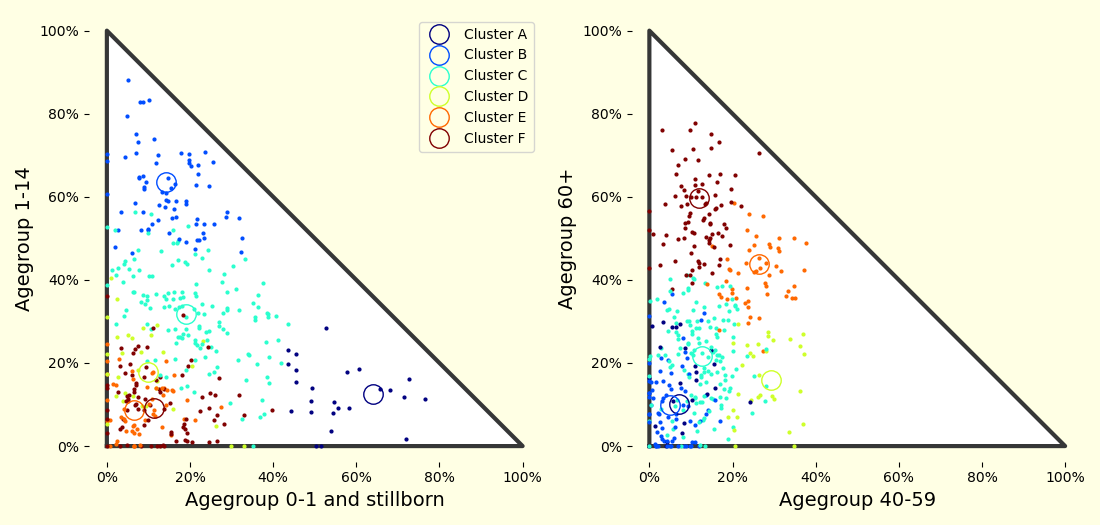

In [212]:
# fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))
# fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,7))
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5.25))

ax1.axis('equal')
ax2.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor)

labelFontSize = 14

# ax1.set_xlabel('Infants and stillborn',fontsize=labelFontSize)
# ax1.set_ylabel('1-14',fontsize=labelFontSize)
# ax2.set_xlabel('40-59',fontsize=labelFontSize)
# ax2.set_ylabel('60+',fontsize=labelFontSize)

ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs + 'Figure_PointcloudMainText')

In [214]:
# clusterNumDict

# plt.close('all')


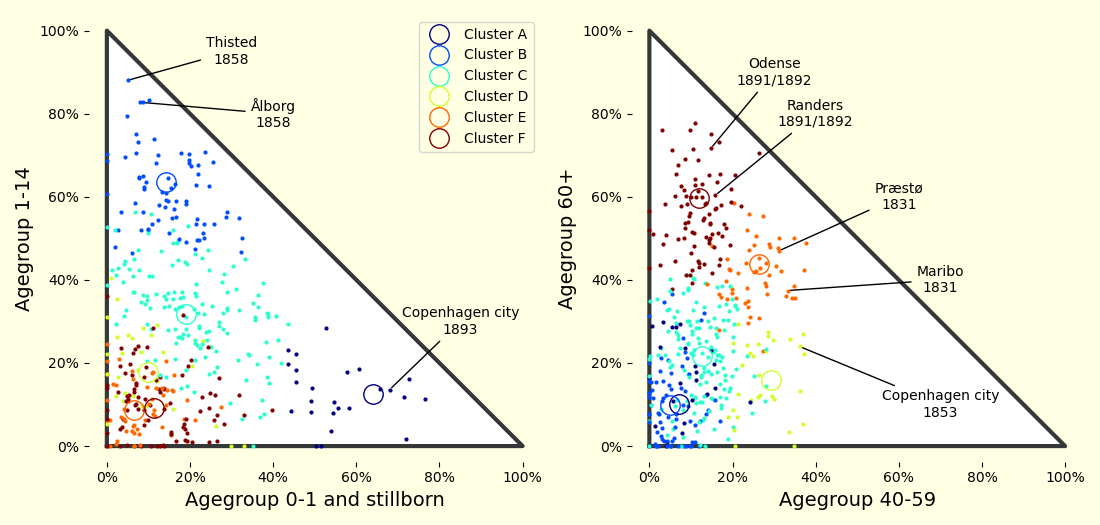

In [215]:
# fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))
# fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,7))
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5.25))

ax1.axis('equal')
ax2.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    # curLabel = r.Amt[:4]+', '+str(r.DayWithMostBurials.year)
    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor,zorder=2)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor,zorder=2)

labelFontSize = 14

# ax1.set_xlabel('Infants and stillborn',fontsize=labelFontSize)
# ax1.set_ylabel('1-14',fontsize=labelFontSize)
# ax2.set_xlabel('40-59',fontsize=labelFontSize)
# ax2.set_ylabel('60+',fontsize=labelFontSize)

ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

#### Label some selected crises
# for i in range(10):
#     r = dfCrisesLabel.loc[i]
#     (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
#     curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
#     curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')

#     # curLabel = 'Copenhagen city\n1853'
#     ax1.annotate(curLabel,(cur1,cur2),(100-cur1,100-cur2),arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)
#     ax2.annotate(curLabel,(cur4,cur5),(100-cur4,100-cur5),arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# # 1831

# First: Cholera, Copenhagen, row 0
i = 0
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')

# curLabel = 'Copenhagen city\n1853'
ax2.annotate(curLabel,(cur4,cur5),(70,10),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 1
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = 'Maribo\n1831'
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,40),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 2
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(60,60),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1858
i = 5
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(30,95),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'B'].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)
# # 1858
# i = 22
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax1.annotate(curLabel,(cur1,cur2),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# High infants
# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'A'].index[0]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(85,30),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 32
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# # curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
# ax1.annotate(curLabel,(cur1,cur2),(60,55),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# # 1891
# i = 9
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
#     curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax2.annotate(curLabel,(cur4,cur5),(50,70),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 14
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[3]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 28
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[2]
r = dfCrises.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
ax2.annotate(curLabel,(cur4,cur5),(30,90),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


# # 1891
# i = 8
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# # curLabel = r.Amt.split(' ')[0] + '\n1891-1892'
# ax2.annotate(curLabel,(cur4,cur5),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs + 'Figure_PointcloudMainText_Labels')

In [216]:
# saveFigures = True
# dfCrises [dfCrises.Start.dt.year == 1891].index
# dfCrises
# dfCrisesLabel.head()
# plt.close('all')

In [217]:
# dfCrisesLabel.head(20)
# dfCrisesLabel[dfCrisesLabel.Cluster == 'E']

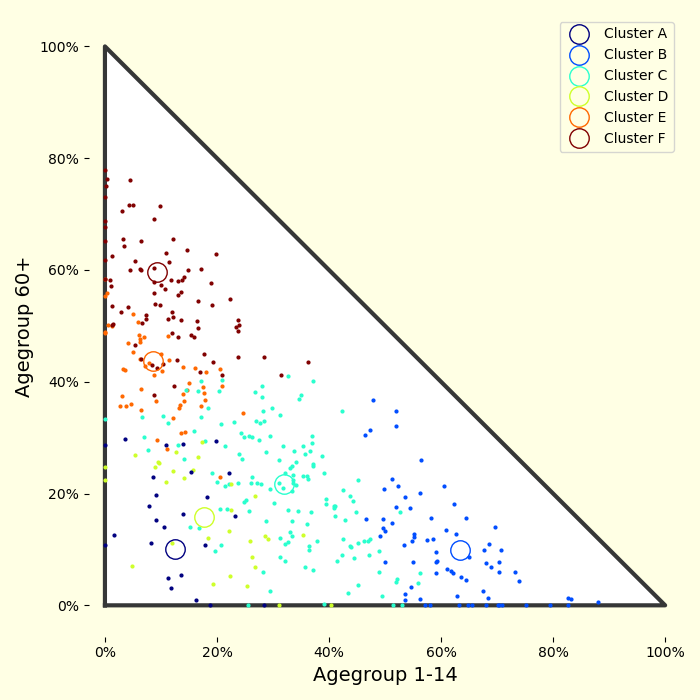

In [218]:
# plt.close('all')
# fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(15,15))
# fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,7))
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    # curColor = cmap(r.Cluster/numClusters)
    # curColor = cmap(curSortIndex[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    ax1.plot(cur2,cur5,'.',ms=4,color=curColor)

labelFontSize = 14

# ax1.set_xlabel('Infants and stillborn',fontsize=labelFontSize)
# ax1.set_ylabel('1-14',fontsize=labelFontSize)
# ax2.set_xlabel('40-59',fontsize=labelFontSize)
# ax2.set_ylabel('60+',fontsize=labelFontSize)

ax1.set_xlabel('Agegroup 1-14',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea2,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    # ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
ax1.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

ax1.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
ax1.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

# ax1.set_xlim([-0.01,1.01])
# ax1.set_ylim([-0.01,1.01])
ax1.set_xlim([-2.5,102.5])
ax1.set_ylim([-2.5,102.5])

ax1.xaxis.set_major_formatter(ticker.PercentFormatter())
ax1.yaxis.set_major_formatter(ticker.PercentFormatter())

ax1.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs+'Figure_PointcloudMainTextExtra')

# Make combined figure used in main text

In [226]:

# clusterNum = 0
# for i,clusterNum in enumerate(range(numClusters)):
#     # curMean = gmm.means_[clusterNum,:]
#     # curMean = gmm.means_[curSortIndex[clusterNum],:]
#     curMean = dfMeans.iloc[clusterNum,:]
    
    
#     mea1,mea2,mea3,mea4,mea5 = (100*curMean)

#     curColor = cmap(i/numClusters)
#     curLabel = 'Cluster '+clusterNameDict[clusterNum]
#     print(curLabel)
# clusterNameDict

# [clusterNameDict[x] for x in dfMeans.index.values] 

['C', 'A', 'B', 'E', 'F', 'D']

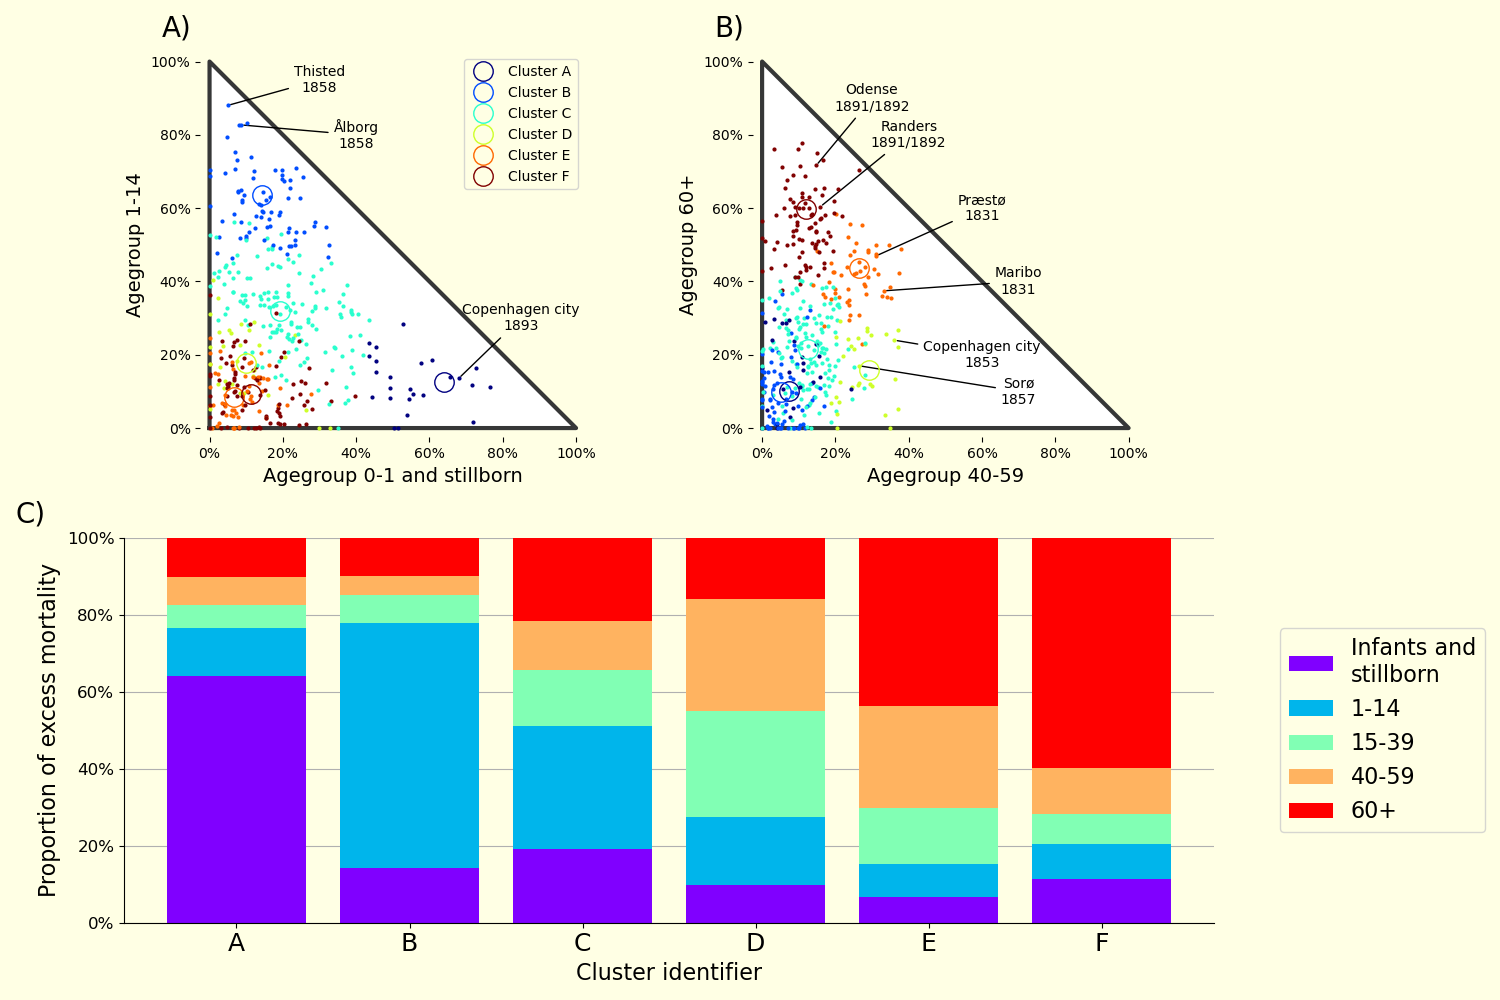

In [227]:

# # dfMeans.columns = ageGroupNames[1:]

# dfMeans.columns = ageGroupNames

# # dfMeans = dfMeans.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
# dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

# fig,ax = plt.subplots(figsize=(12,5))
# # fig,ax = plt.subplots(figsize=(12,5))
fig = plt.figure(figsize=(15,10)) 
ax3 = plt.subplot(212)
(dfMeans * 100).plot.bar(ax=ax3,stacked=True,width=0.8,cmap=cmapBar)
ax3.set_axisbelow(True)
ax3.set_ylim([0,100])
ax3.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax3.set_xlabel('Cluster identifier',fontsize=16)
ax3.set_ylabel('Proportion of excess mortality',fontsize=16)
from matplotlib.ticker import FormatStrFormatter
ax3.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax3.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)

# ax3.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])
ax3.set_xticklabels([clusterNameDict[x] for x in curClusters])


ax1 = plt.subplot(221)
ax2 = plt.subplot(222)

# ax1.axis('equal')
# ax2.axis('equal')
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

# ax1.axis('equal')
# ax2.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    # curColor = cmap(clusterNumDict[r.Cluster]/numClusters)
    # curColor = cmap(clusterNumDict[invMap[r.Cluster]]/numClusters)
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor,zorder=2)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor,zorder=2)

labelFontSize = 14

# ax1.set_xlabel('Infants and stillborn',fontsize=labelFontSize)
# ax1.set_ylabel('1-14',fontsize=labelFontSize)
# ax2.set_xlabel('40-59',fontsize=labelFontSize)
# ax2.set_ylabel('60+',fontsize=labelFontSize)

ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    # curMean = gmm.means_[clusterNum,:]
    # curMean = gmm.means_[curSortIndex[clusterNum],:]
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)


ax1.text(-0.1,1.04,'A)',fontsize=20,transform=ax1.transAxes)
ax2.text(-0.1,1.04,'B)',fontsize=20,transform=ax2.transAxes)
ax3.text(-0.1,1.04,'C)',fontsize=20,transform=ax3.transAxes)

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs+'Figure_ClusteringCombinedFigure')

#### Label some selected crises

# First: Cholera, Copenhagen, row 0
i = 0
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = 'Copenhagen city\n1853'
ax2.annotate(curLabel,(cur4,cur5),(60,20),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1857].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,10),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 1
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = 'Maribo\n1831'
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,40),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 2
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(60,60),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1858
i = 5
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(30,95),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'B'].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)
# # 1858
# i = 22
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax1.annotate(curLabel,(cur1,cur2),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# High infants
# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'A'].index[0]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(85,30),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 32
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# # curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
# ax1.annotate(curLabel,(cur1,cur2),(60,55),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# # 1891
# i = 9
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
#     curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax2.annotate(curLabel,(cur4,cur5),(50,70),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 14
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[3]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 28
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[2]
r = dfCrises.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
ax2.annotate(curLabel,(cur4,cur5),(30,90),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)



fig.tight_layout()



if saveFigures:
    fig.savefig(pathFigs+'Figure_ClusteringCombinedFigure_Labels')
    
# if saveFigures:
#     fig.savefig(pathFigs + 'Figure_PointcloudMainText_Labels')
# fig.tight_layout()

# if saveFigures:
#     fig.savefig(pathFigs+'Supplementary_ClustersIllustration')

In [199]:

# # i = 14
# i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1857].index[2]
# r = dfCrisesLabel.loc[i]
# r
# # (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# # curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# # if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
# #     curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
# # curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# # ax2.annotate(curLabel,(cur4,cur5),(40,80),
# #             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


# Make illustrations of clusters

In [228]:
# # dfCurLabel
# # fracdf
# dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()
# # curSortIndex

# # dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()
# # curSortIndex
# # dfCurLabel
# clusterNameDict.values()

In [229]:
# fracdf.columns = dfMeans.columns 
# testdf.columns = dfMeans.columns 


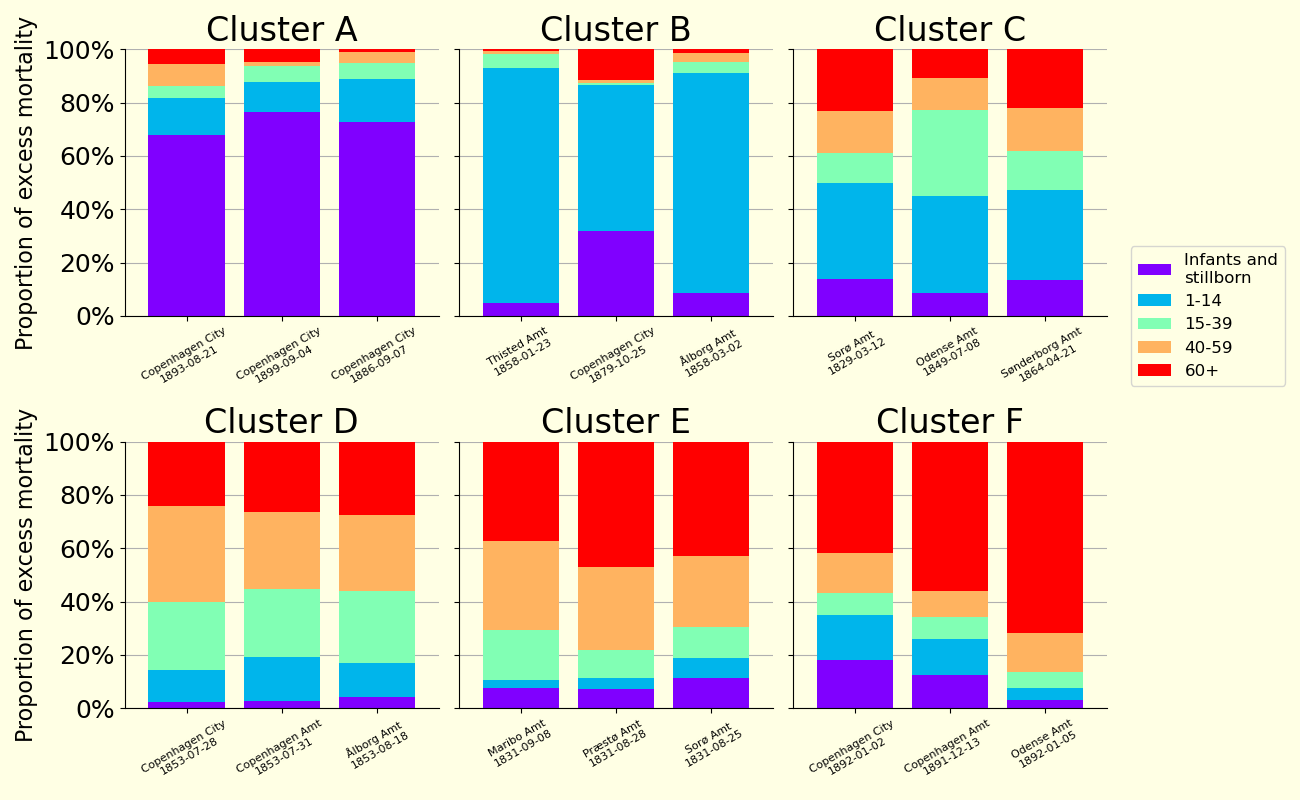

In [230]:

if (numClusters == 6):
    fig,allAxes = plt.subplots(2,3,figsize=(13,8),sharey=True)
elif (numClusters == 7):
    fig,allAxes = plt.subplots(2,4,figsize=(15,8),sharey=True)
    allAxes[1,3].axis(False)
elif (numClusters == 8):
    fig,allAxes = plt.subplots(2,4,figsize=(15,8),sharey=True)

# for i,ax in enumerate(allAxes.flatten()):
axIndex = 0
# for i in curSortIndex:
for i in clusterNameDict.values():

    ax = allAxes.flatten()[axIndex]
    axIndex += 1



    dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()

    dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()
    dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Københavns Amt','Copenhagen Amt')
    dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Staden København','Copenhagen City')
    
    # # Sort by how well the crises fit in the cluster 
    # dfCurLabel = dfCurLabel.sort_values(f'Cluster{i}_Prob',ascending=False)

    
    # testdf = dfCurLabel[ageGroupNames].copy()
    # # testdf = dfCrisesLabel.loc[dfCrisesLabel.Cluster == 7,ageGroupNames].copy()
    # testdf[testdf < 0] = 0
    # curSum = testdf.sum(axis=1)
    # testdf = testdf.apply(lambda x: x/curSum)

    testdf = fracdf.loc[dfCurLabel.index]

    # testdf = testdf.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
    # testdf = testdf.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})
    testdf.columns = dfMeans.columns 


    (testdf.iloc[:3] * 100).plot.bar(ax=ax,stacked=True,width=0.8,legend=False,cmap=cmapBar)

    dfCurToTicks = dfCurLabel.loc[testdf.iloc[:3].index]
    curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostDeaths.dt.year.astype(str)
    curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostDeaths.astype(str)
    ax.set_xticklabels(curXlabels.values,rotation=30,fontsize=8)

    ax.set_axisbelow(True)
    ax.set_ylim([0,100])
    # ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
    # ax.set_xlabel('Cluster identifier')
    ax.set_ylabel('Proportion of excess mortality',fontsize=16)
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
    
    # ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)

    ax.set_title(f'Cluster {i}')
    # ax.set_title(f'Cluster {clusterNameDict[i]}')

if (numClusters == 6):
    allAxes.flatten()[2].legend(bbox_to_anchor=(1.05,0),loc='center left',fontsize=12)
elif (numClusters == 7):
    ax = allAxes.flatten()[-1]
    (testdf.iloc[:3] * 0).plot.bar(ax=ax,stacked=True,width=0.8,legend=False,cmap=cmapBar)
    ax.legend(loc='center',fontsize=16)
elif (numClusters == 8):
    allAxes.flatten()[3].legend(bbox_to_anchor=(1.05,0),loc='center left',fontsize=12)


fig.tight_layout()
if saveFigures:
    fig.savefig(pathFigs+'ClustersExamples')

In [231]:
# testdf
# dfCrisesLabel

,Amt,Start,End,NumberOfDays,DayWithMostDeaths,Excess,ExcessPct,GenderRatio,TimeOfYear,Season,...,FracAll_40-59,FracAll_60+,AgeSplitSumExc,Cluster,ClusterA_Prob,ClusterB_Prob,ClusterC_Prob,ClusterD_Prob,ClusterE_Prob,ClusterF_Prob
0,Staden København,1853-07-02,1853-09-07,67,1853-07-28,3833,546.0,0.468578,Q3,Summer,...,0.361178,0.239741,3679.206677,D,0.0000,0.0000,0.0,0.0000,0.9897,0.0103
1,Maribo Amt,1831-08-01,1832-07-06,340,1831-09-08,2181,150.0,0.504945,Q3,Fall,...,0.332261,0.374465,2223.185300,E,0.0000,0.0000,0.0,0.0000,0.1376,0.8624
2,Præstø Amt,1831-07-30,1831-12-14,137,1831-08-28,1563,392.0,0.512232,Q3,Summer,...,0.310643,0.469577,1585.356806,E,0.0000,0.0000,0.0,0.0001,0.0006,0.9993
3,Sorø Amt,1831-08-05,1832-01-18,166,1831-08-25,1230,261.0,0.495591,Q3,Summer,...,0.267058,0.427939,1242.062185,E,0.0000,0.0011,0.0,0.0010,0.0008,0.9972
4,Holbæk Amt,1831-08-02,1832-02-06,188,1831-08-26,1217,209.0,0.528365,Q3,Summer,...,0.280702,0.439973,1250.687976,E,0.0000,0.0003,0.0,0.0003,0.0010,0.9984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,Århus Amt,1874-06-12,1874-06-30,18,1874-06-15,50,37.0,0.526882,Q2,Summer,...,0.142176,0.180562,54.439488,C,0.0003,0.9984,0.0,0.0000,0.0005,0.0008
414,Københavns Amt,1827-11-18,1827-12-13,25,1827-11-22,50,33.0,0.512438,Q4,Fall,...,0.168936,0.205437,61.898410,C,0.0034,0.9960,0.0,0.0000,0.0000,0.0005
415,Svendborg Amt,1828-04-08,1828-04-23,15,1828-04-11,50,72.0,0.566667,Q2,Spring,...,0.106846,0.231428,55.341201,C,0.0011,0.9986,0.0,0.0003,0.0000,0.0000
416,Ålborg Amt,1900-04-27,1900-05-14,17,1900-05-07,50,42.0,0.517647,Q2,Spring,...,0.120040,0.431432,56.009990,F,0.0000,0.2226,0.0,0.6661,0.0000,0.1113


In [75]:

# # for i,ax in enumerate(allAxes.flatten()):
# axIndex = 0
# # for i in curSortIndex[:4]:
# # for i in curSortIndex:
# for i in clusterNameDict.values():

#     # ax = allAxes.flatten()[axIndex]
#     # axIndex += 1

#     fig,ax = plt.subplots(figsize=(20,6))



#     dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()
#     dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Københavns Amt','Copenhagen Amt')
#     dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Staden København','Copenhagen City')

    
#     # testdf = dfCurLabel[ageGroupNames].copy()
#     # # testdf = dfCrisesLabel.loc[dfCrisesLabel.Cluster == 7,ageGroupNames].copy()
#     # testdf[testdf < 0] = 0
#     # curSum = testdf.sum(axis=1)
#     # testdf = testdf.apply(lambda x: x/curSum)

#     testdf = fracdf.loc[dfCurLabel.index]

#     # testdf = testdf.rename(columns={'Infants and stillborn': 'Infants and\nstillborn'})
#     # testdf = testdf.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})
#     testdf.columns = dfMeans.columns 


#     numToShow = len(testdf)
#     (testdf.iloc[:numToShow] * 100).plot.bar(ax=ax,stacked=True,width=0.8,legend=False,cmap=cmapBar)

#     dfCurToTicks = dfCurLabel.loc[testdf.iloc[:numToShow].index]
#     curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostBurials.dt.year.astype(str)
#     curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostBurials.astype(str)
#     ax.set_xticklabels(curXlabels.values,rotation=90,fontsize=8)

#     ax.set_axisbelow(True)
#     ax.set_ylim([0,100])
#     # ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
#     # ax.set_xlabel('Cluster identifier')
#     ax.set_ylabel('Proportion of excess mortality',fontsize=16)
#     from matplotlib.ticker import FormatStrFormatter
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))

#     ax.set_title(f'Cluster {i}')
#     # ax.set_title(f'Cluster {clusterNameDict[i]}')

#     ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=12)

#     fig.tight_layout()
#     if saveFigures:
#         fig.savefig(pathFigs+f'ClustersAll_{i}')

In [76]:
plt.close('all')

In [77]:
# # dfCrisesLabel.loc[1].Amt.split(' ')[0]
# # dfCrisesLabel.loc[1].DayWithMostBurials.year
# dfCrisesLabel.head(20)
# # r
# dfCrisesLabel.sort_values('FracAll_Infants_stillborn',ascending=False).head(20)
# dfCrisesLabel[dfCrisesLabel['FracAll_Infants_stillborn'] > 0.3].head(20)
# dfCrisesLabel[dfCrisesLabel['FracAll_1-14'] > 0.6].head(20)

# # dfCrisesLabel.columns